In [1]:
from __future__ import print_function
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.contrib.eager as tfe
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook, tqdm, trange
tfe.enable_eager_execution()
print(tf.__version__)

1.12.0


In [2]:
tf.set_random_seed(2)

In [3]:
(x_train, y_train), (x_test , y_test) = tf.keras.datasets.mnist.load_data()
x_train = (x_train/255).astype(np.float32)
x_test = (x_test/255).astype(np.float32)

val_range = int(len(x_test) * 0.8)

x_val = x_test[:val_range, :]
y_val = y_test[:val_range]

x_test = x_test[val_range:, :]
y_test = y_test[val_range:]

x_train = x_train.reshape((-1, 28, 28, 1))
x_val = x_val.reshape((-1, 28, 28, 1))
x_test = x_test.reshape((-1, 28, 28, 1))

11493376/11490434 [==============================] - 1s 0us/step


In [4]:
# Loss function
def loss_fn(model, x, y):
    logits = model(x)
    y = tf.dtypes.cast(y, tf.int32)
    return tf.losses.sparse_softmax_cross_entropy(labels=y, logits=logits)

In [5]:
# Hyper Parameters
epoch = 100
batch_size = 100
learning_rate = 0.005
total_step = int(x_train.shape[0] / batch_size)

# creating optimizer
opt = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)

In [6]:
# train
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=10000)
train_dataset = train_dataset.batch(batch_size=batch_size)
print(train_dataset)

# validation
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.shuffle(buffer_size=10000)
val_dataset = val_dataset.batch(batch_size=batch_size)
print(val_dataset)

# test
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.shuffle(buffer_size=10000)
test_dataset = test_dataset.batch(batch_size=batch_size)
print(test_dataset)

<BatchDataset shapes: ((?, 28, 28, 1), (?,)), types: (tf.float32, tf.uint8)>
<BatchDataset shapes: ((?, 28, 28, 1), (?,)), types: (tf.float32, tf.uint8)>
<BatchDataset shapes: ((?, 28, 28, 1), (?,)), types: (tf.float32, tf.uint8)>


# Batch Normalization + L2 Norm CNN

In [7]:
class BathNormL2NormCNN(keras.Model):
    def __init__(self, num_classes=10):
        super(BathNormL2NormCNN, self).__init__()
        self._layer1 = keras.layers.Conv2D(32, (3, 3), padding='same', strides=(1, 1), activation='linear',
                                           kernel_initializer='he_normal', kernel_regularizer=keras.regularizers.l2(0.01))
        self._layer2 = keras.layers.BatchNormalization()
        self._layer3 = keras.layers.Activation('relu')
        
        self._layer4 = keras.layers.MaxPool2D()
        
        self._layer5 = keras.layers.Conv2D(64, (3, 3), padding='same', strides=(1, 1), activation='linear',
                                           kernel_initializer='he_normal', kernel_regularizer=keras.regularizers.l2(0.01))
        self._layer6 = keras.layers.BatchNormalization()
        self._layer7 = keras.layers.Activation('relu')
        
        self._layer8 = keras.layers.MaxPool2D()
        
        self._layer9 = keras.layers.Conv2D(128, (3, 3), padding='same', strides=(1, 1), activation='linear',
                                           kernel_initializer='he_normal', kernel_regularizer=keras.regularizers.l2(0.01))
        self._layer10 = keras.layers.BatchNormalization()
        self._layer11 = keras.layers.Activation('relu')
        
        self._layer12 = keras.layers.MaxPool2D()
        
        self._layer13 = keras.layers.Flatten()
        self._layer14 = keras.layers.Dense(100, activation='tanh')
        self._layer15 = keras.layers.Dense(10, activation='softmax')
        
        self.train_loss_hist = []
        self.val_loss_hist = []

    def call(self, inputs):
        out = self._layer1(inputs)
        out = self._layer2(out)
        out = self._layer3(out)
        out = self._layer4(out)
        out = self._layer5(out)
        out = self._layer6(out)
        out = self._layer7(out)
        out = self._layer8(out)
        out = self._layer9(out)
        out = self._layer10(out)
        out = self._layer11(out)
        out = self._layer12(out)
        out = self._layer13(out)
        out = self._layer14(out)
        out = self._layer15(out)
        return out

In [8]:
bathNormL2NormCNN = BathNormL2NormCNN()

In [9]:
# training
total_bar_length = tqdm_notebook(range(epoch))

device = '\cpu:0' if tfe.num_gpus() == 0 else 'gpu:0'
with tf.device(device):
    for i in total_bar_length:

        avg_train_loss = 0
        avg_val_loss = 0
        train_step = 0
        val_step = 0

        # training
        with tf.contrib.summary.always_record_summaries():
            for x, y in train_dataset:
                with tf.GradientTape() as tape:
                    train_loss = loss_fn(bathNormL2NormCNN, x, y)
                grads = tape.gradient(target=train_loss, sources=bathNormL2NormCNN.variables)
                opt.apply_gradients(grads_and_vars=zip(grads, bathNormL2NormCNN.variables))                
                avg_train_loss += train_loss
                train_step += 1
            else:
                avg_train_loss /= train_step
                bathNormL2NormCNN.train_loss_hist.append(avg_train_loss)

            # validation
            for _x, _y in val_dataset:
                val_loss = loss_fn(bathNormL2NormCNN, _x, _y)                
                avg_val_loss += val_loss
                val_step += 1
            else:
                avg_val_loss /= val_step
                bathNormL2NormCNN.val_loss_hist.append(avg_val_loss)

        if (i + 1) % 10 == 0:
            print("epoch : {:3}, train_loss : {:.2f}, val_loss : {:.2f}".format(i, avg_train_loss, avg_val_loss))

epoch :   9, train_loss : 1.52, val_loss : 1.52
epoch :  19, train_loss : 1.50, val_loss : 1.50
epoch :  29, train_loss : 1.49, val_loss : 1.49
epoch :  39, train_loss : 1.48, val_loss : 1.49
epoch :  49, train_loss : 1.48, val_loss : 1.49
epoch :  59, train_loss : 1.48, val_loss : 1.48
epoch :  69, train_loss : 1.48, val_loss : 1.48
epoch :  79, train_loss : 1.47, val_loss : 1.48
epoch :  89, train_loss : 1.47, val_loss : 1.48
epoch :  99, train_loss : 1.47, val_loss : 1.48



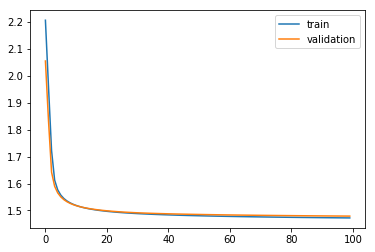

In [10]:
plt.plot(bathNormL2NormCNN.train_loss_hist, label="train")
plt.plot(bathNormL2NormCNN.val_loss_hist, label="validation")
plt.legend()
plt.show()

In [11]:
scores = list()
yhat = list()
for __x, __y in test_dataset:
    out = bathNormL2NormCNN.call(__x)
    score = np.argmax(out, axis=1)
    
    scores.extend(score.tolist())
    yhat.extend(__y.numpy().tolist())

scores = np.asarray(scores)
yhat = np.asarray(yhat)Q

print("acc : {:.2%}".format(np.mean(yhat == scores)))

acc : 99.35%


# Pure CNN

In [12]:
class PureCNN(keras.Model):
    def __init__(self, num_classes=10):
        super(PureCNN, self).__init__()
        self._layer1 = keras.layers.Conv2D(32, (3, 3), padding='same', strides=(1, 1), activation='linear',
                                           kernel_initializer='he_normal')        
        self._layer2 = keras.layers.Activation('relu')        
        self._layer3 = keras.layers.MaxPool2D()
        
        self._layer4 = keras.layers.Conv2D(64, (3, 3), padding='same', strides=(1, 1), activation='linear',
                                           kernel_initializer='he_normal')        
        self._layer5 = keras.layers.Activation('relu')        
        self._layer6 = keras.layers.MaxPool2D()
        
        self._layer7 = keras.layers.Conv2D(128, (3, 3), padding='same', strides=(1, 1), activation='linear',
                                           kernel_initializer='he_normal')        
        self._layer8 = keras.layers.Activation('relu')    
        self._layer9 = keras.layers.MaxPool2D()
        
        self._layer10 = keras.layers.Flatten()
        self._layer11 = keras.layers.Dense(100, activation='tanh')
        self._layer12 = keras.layers.Dense(10, activation='softmax')
        
        self.train_loss_hist = []
        self.val_loss_hist = []

    def call(self, inputs):
        out = self._layer1(inputs)
        out = self._layer2(out)
        out = self._layer3(out)
        out = self._layer4(out)
        out = self._layer5(out)
        out = self._layer6(out)
        out = self._layer7(out)
        out = self._layer8(out)
        out = self._layer9(out)
        out = self._layer10(out)
        out = self._layer11(out)        
        out = self._layer12(out)
        return out

In [13]:
pureCNN = PureCNN()

In [14]:
# training
total_bar_length = tqdm_notebook(range(epoch))

device = '\cpu:0' if tfe.num_gpus() == 0 else 'gpu:0'
with tf.device(device):
    for i in total_bar_length:

        avg_train_loss = 0
        avg_val_loss = 0
        train_step = 0
        val_step = 0

        # training
        with tf.contrib.summary.always_record_summaries():
            for x, y in train_dataset:
                with tf.GradientTape() as tape:
                    train_loss = loss_fn(pureCNN, x, y)
                grads = tape.gradient(target=train_loss, sources=pureCNN.variables)
                opt.apply_gradients(grads_and_vars=zip(grads, pureCNN.variables))                
                avg_train_loss += train_loss
                train_step += 1
            else:
                avg_train_loss /= train_step
                pureCNN.train_loss_hist.append(avg_train_loss)

            # validation
            for _x, _y in val_dataset:
                val_loss = loss_fn(pureCNN, _x, _y)                
                avg_val_loss += val_loss
                val_step += 1
            else:
                avg_val_loss /= val_step
                pureCNN.val_loss_hist.append(avg_val_loss)

        if (i + 1) % 10 == 0:
            print("epoch : {:3}, train_loss : {:.2f}, val_loss : {:.2f}".format(i, avg_train_loss, avg_val_loss))

epoch :   9, train_loss : 1.52, val_loss : 1.52
epoch :  19, train_loss : 1.50, val_loss : 1.50
epoch :  29, train_loss : 1.49, val_loss : 1.49
epoch :  39, train_loss : 1.48, val_loss : 1.49
epoch :  49, train_loss : 1.48, val_loss : 1.49
epoch :  59, train_loss : 1.48, val_loss : 1.48
epoch :  69, train_loss : 1.48, val_loss : 1.48
epoch :  79, train_loss : 1.48, val_loss : 1.48
epoch :  89, train_loss : 1.47, val_loss : 1.48
epoch :  99, train_loss : 1.47, val_loss : 1.48



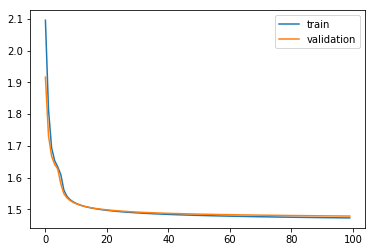

In [15]:
plt.plot(pureCNN.train_loss_hist, label="train")
plt.plot(pureCNN.val_loss_hist, label="validation")
plt.legend()
plt.show()

In [16]:
scores = list()
yhat = list()
for __x, __y in test_dataset:
    out = pureCNN.call(__x)
    score = np.argmax(out, axis=1)
    
    scores.extend(score.tolist())
    yhat.extend(__y.numpy().tolist())

scores = np.asarray(scores)
yhat = np.asarray(yhat)

print("acc : {:.2%}".format(np.mean(yhat == scores)))

acc : 99.25%


# L2 Norm CNN

In [17]:
class L2NormCNN(keras.Model):
    def __init__(self, num_classes=10):
        super(L2NormCNN, self).__init__()
        self._layer1 = keras.layers.Conv2D(32, (3, 3), padding='same', strides=(1, 1), activation='linear',
                                           kernel_initializer='he_normal', kernel_regularizer=keras.regularizers.l2(0.01))        
        self._layer2 = keras.layers.Activation('relu')        
        self._layer3 = keras.layers.MaxPool2D()
        
        self._layer4 = keras.layers.Conv2D(64, (3, 3), padding='same', strides=(1, 1), activation='linear',
                                           kernel_initializer='he_normal', kernel_regularizer=keras.regularizers.l2(0.01))        
        self._layer5 = keras.layers.Activation('relu')        
        self._layer6 = keras.layers.MaxPool2D()
        
        self._layer7 = keras.layers.Conv2D(128, (3, 3), padding='same', strides=(1, 1), activation='linear',
                                           kernel_initializer='he_normal', kernel_regularizer=keras.regularizers.l2(0.01))        
        self._layer8 = keras.layers.Activation('relu')        
        self._layer9 = keras.layers.MaxPool2D()
        
        self._layer10 = keras.layers.Flatten()
        self._layer11 = keras.layers.Dense(100, activation='tanh')
        self._layer12 = keras.layers.Dense(10, activation='softmax')
        
        self.train_loss_hist = []
        self.val_loss_hist = []

    def call(self, inputs):
        out = self._layer1(inputs)
        out = self._layer2(out)
        out = self._layer3(out)
        out = self._layer4(out)
        out = self._layer5(out)
        out = self._layer6(out)
        out = self._layer7(out)
        out = self._layer8(out)
        out = self._layer9(out)
        out = self._layer10(out)
        out = self._layer11(out)        
        out = self._layer12(out)
        return out

In [18]:
l2NormCNN = L2NormCNN()

In [19]:
# training
total_bar_length = tqdm_notebook(range(epoch))

device = '\cpu:0' if tfe.num_gpus() == 0 else 'gpu:0'
with tf.device(device):
    for i in total_bar_length:

        avg_train_loss = 0
        avg_val_loss = 0
        train_step = 0
        val_step = 0

        # training
        with tf.contrib.summary.always_record_summaries():
            for x, y in train_dataset:
                with tf.GradientTape() as tape:
                    train_loss = loss_fn(l2NormCNN, x, y)
                grads = tape.gradient(target=train_loss, sources=l2NormCNN.variables)
                opt.apply_gradients(grads_and_vars=zip(grads, l2NormCNN.variables))                
                avg_train_loss += train_loss
                train_step += 1
            else:
                avg_train_loss /= train_step
                l2NormCNN.train_loss_hist.append(avg_train_loss)

            # validation
            for _x, _y in val_dataset:
                val_loss = loss_fn(l2NormCNN, _x, _y)                
                avg_val_loss += val_loss
                val_step += 1
            else:
                avg_val_loss /= val_step
                l2NormCNN.val_loss_hist.append(avg_val_loss)

        if (i + 1) % 10 == 0:
            print("epoch : {:3}, train_loss : {:.2f}, val_loss : {:.2f}".format(i, avg_train_loss, avg_val_loss))

epoch :   9, train_loss : 1.53, val_loss : 1.53
epoch :  19, train_loss : 1.50, val_loss : 1.50
epoch :  29, train_loss : 1.49, val_loss : 1.49
epoch :  39, train_loss : 1.49, val_loss : 1.49
epoch :  49, train_loss : 1.48, val_loss : 1.48
epoch :  59, train_loss : 1.48, val_loss : 1.48
epoch :  69, train_loss : 1.48, val_loss : 1.48
epoch :  79, train_loss : 1.48, val_loss : 1.48
epoch :  89, train_loss : 1.47, val_loss : 1.48
epoch :  99, train_loss : 1.47, val_loss : 1.48



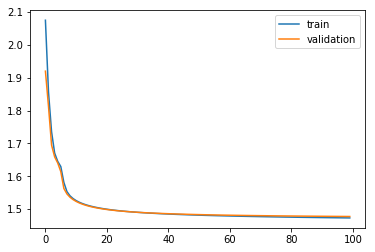

In [20]:
plt.plot(l2NormCNN.train_loss_hist, label="train")
plt.plot(l2NormCNN.val_loss_hist, label="validation")
plt.legend()
plt.show()

In [21]:
scores = list()
yhat = list()
for __x, __y in test_dataset:
    out = l2NormCNN.call(__x)
    score = np.argmax(out, axis=1)
    
    scores.extend(score.tolist())
    yhat.extend(__y.numpy().tolist())

scores = np.asarray(scores)
yhat = np.asarray(yhat)

print("acc : {:.2%}".format(np.mean(yhat == scores)))

acc : 98.90%


# Batch Normalization CNN

In [22]:
class BatchNormCNN(keras.Model):
    def __init__(self, num_classes=10):
        super(BatchNormCNN, self).__init__()
        self._layer1 = keras.layers.Conv2D(32, (3, 3), padding='same', strides=(1, 1), activation='linear',
                                           kernel_initializer='he_normal')
        self._layer2 = keras.layers.BatchNormalization()
        self._layer3 = keras.layers.Activation('relu')        
        self._layer4 = keras.layers.MaxPool2D()
        
        self._layer5 = keras.layers.Conv2D(64, (3, 3), padding='same', strides=(1, 1), activation='linear',
                                           kernel_initializer='he_normal')
        self._layer6 = keras.layers.BatchNormalization()
        self._layer7 = keras.layers.Activation('relu')        
        self._layer8 = keras.layers.MaxPool2D()
        
        self._layer9 = keras.layers.Conv2D(128, (3, 3), padding='same', strides=(1, 1), activation='linear',
                                           kernel_initializer='he_normal')
        self._layer10 = keras.layers.BatchNormalization()
        self._layer11 = keras.layers.Activation('relu')        
        self._layer12 = keras.layers.MaxPool2D()
        
        self._layer13 = keras.layers.Flatten()
        self._layer14 = keras.layers.Dense(100, activation='tanh')
        self._layer15 = keras.layers.Dense(10, activation='softmax')
        
        self.train_loss_hist = []
        self.val_loss_hist = []

    def call(self, inputs):
        out = self._layer1(inputs)
        out = self._layer2(out)
        out = self._layer3(out)
        out = self._layer4(out)
        out = self._layer5(out)
        out = self._layer6(out)
        out = self._layer7(out)
        out = self._layer8(out)
        out = self._layer9(out)
        out = self._layer10(out)
        out = self._layer11(out)
        out = self._layer12(out)
        out = self._layer13(out)
        out = self._layer14(out)
        out = self._layer15(out)
        return out

In [23]:
batchNormCNN = BatchNormCNN()

In [24]:
# training
total_bar_length = tqdm_notebook(range(epoch))

device = '\cpu:0' if tfe.num_gpus() == 0 else 'gpu:0'
with tf.device(device):
    for i in total_bar_length:

        avg_train_loss = 0
        avg_val_loss = 0
        train_step = 0
        val_step = 0

        # training
        with tf.contrib.summary.always_record_summaries():
            for x, y in train_dataset:
                with tf.GradientTape() as tape:
                    train_loss = loss_fn(batchNormCNN, x, y)
                grads = tape.gradient(target=train_loss, sources=batchNormCNN.variables)
                opt.apply_gradients(grads_and_vars=zip(grads, batchNormCNN.variables))                
                avg_train_loss += train_loss
                train_step += 1
            else:
                avg_train_loss /= train_step
                batchNormCNN.train_loss_hist.append(avg_train_loss)

            # validation
            for _x, _y in val_dataset:
                val_loss = loss_fn(batchNormCNN, _x, _y)                
                avg_val_loss += val_loss
                val_step += 1
            else:
                avg_val_loss /= val_step
                batchNormCNN.val_loss_hist.append(avg_val_loss)

        if (i + 1) % 10 == 0:
            print("epoch : {:3}, train_loss : {:.2f}, val_loss : {:.2f}".format(i, avg_train_loss, avg_val_loss))

epoch :   9, train_loss : 1.52, val_loss : 1.52
epoch :  19, train_loss : 1.50, val_loss : 1.50
epoch :  29, train_loss : 1.49, val_loss : 1.49
epoch :  39, train_loss : 1.48, val_loss : 1.49
epoch :  49, train_loss : 1.48, val_loss : 1.48
epoch :  59, train_loss : 1.48, val_loss : 1.48
epoch :  69, train_loss : 1.48, val_loss : 1.48
epoch :  79, train_loss : 1.47, val_loss : 1.48
epoch :  89, train_loss : 1.47, val_loss : 1.48
epoch :  99, train_loss : 1.47, val_loss : 1.48



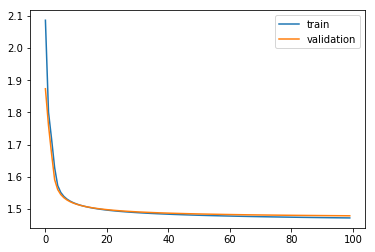

In [25]:
plt.plot(batchNormCNN.train_loss_hist, label="train")
plt.plot(batchNormCNN.val_loss_hist, label="validation")
plt.legend()
plt.show()

In [26]:
scores = list()
yhat = list()
for __x, __y in test_dataset:
    out = batchNormCNN.call(__x)
    score = np.argmax(out, axis=1)
    
    scores.extend(score.tolist())
    yhat.extend(__y.numpy().tolist())

scores = np.asarray(scores)
yhat = np.asarray(yhat)

print("acc : {:.2%}".format(np.mean(yhat == scores)))

acc : 99.40%


# Batch Normalization + L2 Norm CNN

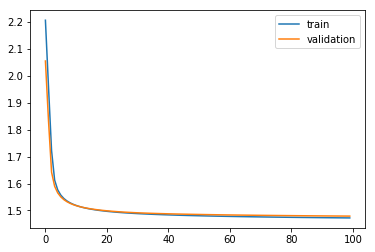

In [28]:
plt.plot(bathNormL2NormCNN.train_loss_hist, label="train")
plt.plot(bathNormL2NormCNN.val_loss_hist, label="validation")
plt.legend()
plt.show()

In [31]:
scores = list()
yhat = list()
for __x, __y in test_dataset:
    out = bathNormL2NormCNN.call(__x)
    score = np.argmax(out, axis=1)
    
    scores.extend(score.tolist())
    yhat.extend(__y.numpy().tolist())

scores = np.asarray(scores)
yhat = np.asarray(yhat)

print("acc : {:.2%}".format(np.mean(yhat == scores)))

acc : 99.35%


In [53]:
comparision1 = BathNormL2NormCNN()
print(bathNormL2NormCNN.variables[2])
print(bathNormL2NormCNN.variables[3])

<tf.Variable 'bath_norm_l2_norm_cnn/batch_normalization/gamma:0' shape=(32,) dtype=float32, numpy=
array([ 1.01601386,  1.14143002,  0.99628872,  1.27449   ,  1.00171113,
        1.47389853,  1.13910401,  1.36294842,  1.07814348,  1.03184509,
        1.0809176 ,  1.22293437,  1.04192936,  1.10699534,  1.00090849,
        1.01065683,  1.07155108,  1.00258553,  1.00808787,  1.02066529,
        0.99842399,  1.05130005,  0.99456841,  1.05583096,  1.04242384,
        1.00880158,  1.15672314,  1.0164423 ,  1.05168521,  1.05439186,
        1.40194738,  1.0263921 ], dtype=float32)>
<tf.Variable 'bath_norm_l2_norm_cnn/batch_normalization/beta:0' shape=(32,) dtype=float32, numpy=
array([  4.89750710e-05,   1.47651695e-02,  -4.26575728e-02,
        -7.42603806e-05,  -1.35642595e-05,   2.31725193e-04,
        -7.00390228e-05,   1.37685493e-04,   1.33578507e-02,
         5.77017665e-03,  -6.58538338e-05,  -1.22230282e-04,
        -7.30222138e-03,   1.19097950e-03,   2.52568349e-02,
        -2.25144

# L2 Norm CNN

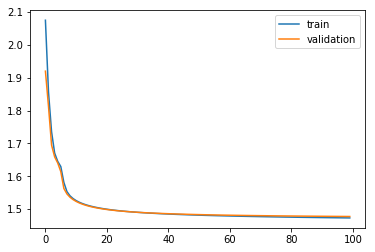

In [34]:
plt.plot(l2NormCNN.train_loss_hist, label="train")
plt.plot(l2NormCNN.val_loss_hist, label="validation")
plt.legend()
plt.show()

In [35]:
scores = list()
yhat = list()
for __x, __y in test_dataset:
    out = l2NormCNN.call(__x)
    score = np.argmax(out, axis=1)
    
    scores.extend(score.tolist())
    yhat.extend(__y.numpy().tolist())

scores = np.asarray(scores)
yhat = np.asarray(yhat)

print("acc : {:.2%}".format(np.mean(yhat == scores)))

acc : 98.90%


# Pure CNN

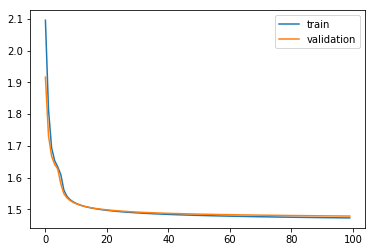

In [32]:
plt.plot(pureCNN.train_loss_hist, label="train")
plt.plot(pureCNN.val_loss_hist, label="validation")
plt.legend()
plt.show()

In [33]:
scores = list()
yhat = list()
for __x, __y in test_dataset:
    out = pureCNN.call(__x)
    score = np.argmax(out, axis=1)
    
    scores.extend(score.tolist())
    yhat.extend(__y.numpy().tolist())

scores = np.asarray(scores)
yhat = np.asarray(yhat)

print("acc : {:.2%}".format(np.mean(yhat == scores)))

acc : 99.25%


# Batch Normalization CNN

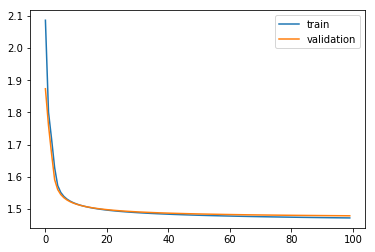

In [36]:
plt.plot(batchNormCNN.train_loss_hist, label="train")
plt.plot(batchNormCNN.val_loss_hist, label="validation")
plt.legend()
plt.show()

In [37]:
scores = list()
yhat = list()
for __x, __y in test_dataset:
    out = batchNormCNN.call(__x)
    score = np.argmax(out, axis=1)
    
    scores.extend(score.tolist())
    yhat.extend(__y.numpy().tolist())

scores = np.asarray(scores)
yhat = np.asarray(yhat)

print("acc : {:.2%}".format(np.mean(yhat == scores)))

acc : 99.40%
